# DQN algorithm

-------------

Heavily based on [this](https://blog.gofynd.com/building-a-deep-q-network-in-pytorch-fa1086aa5435) blogpost

-------------
Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

Since our environment is deterministic, such function must exists.

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

Using  $\delta$ as a measure of error we train $Q^{\pi}$

However... Using this algorithm in its unchanged form has proven to be extremely unstable.

The reward function defined in CartPole-v1 is extremely uninformative. It is basically a constant, except for the very last step when the model fails.

In order to achieve stability I had to modify the reward by adding $-|\theta|$ to the reward, returned by the environment.

This addition leads to training being successful independent of the random seed.

<!-- Further addition of term $-|x|/10$ helped to make sure the cart stays at the center of the screen/ -->
Further addition of term $-|x|/10$ helped to stabilize the latest stages of the training even further. 

<!-- To minimise this error, we will use the [`Huber loss `](<https://en.wikipedia.org/wiki/Huber_loss>). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}
 -->



In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm
from time import sleep

In [29]:
class DQN_Agent:
    
    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.q_net.cuda()
        self.target_net.cuda()
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen = exp_replay_size)  
        return
        
    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
            layers += (linear,act)
        return nn.Sequential(*layers)
    
    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q,A = torch.max(Qp, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0,action_space_len,(1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q,_ = torch.max(qp, axis=1)    
        return q
    
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return
    
    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)   
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()   
        return s, a, rn, sn
    
    def train(self, batch_size ):
        s, a, rn, sn = self.sample_from_experience( sample_size = batch_size)
        if(self.network_sync_counter == self.network_sync_freq):
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0
        
        # predict expected return of current state using main network
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)
        
        # get target return using target network
        q_next = self.get_q_next(sn.cuda())
        target_return = rn.cuda() + self.gamma * q_next
        
        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        
        self.network_sync_counter += 1       
        return loss.item()

In [39]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed = 1421, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)
# agent = DQN_Agent(seed = 1425, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)

# initiliaze experiance replay      
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while(done != True):
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if( index > exp_replay_size ):
            break
            

In [40]:
# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
def plot_progress():
    plt.plot(losses_list)
    plt.title('Loss')
    plt.show()
    plt.plot(reward_list)
    plt.title('Reward')
    plt.show()
    plt.plot(episode_len_list)
    plt.title('Episode length')
    plt.show()
    # plt.plot(epsilon_list)
    # plt.title('Epsilon')
    # plt.show()
index = 128
episodes = 6500
# episodes = 10000
delimiter = 500
epsilon = 1

In [56]:
def theta_to_reward(theta):
    return -abs(theta)
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while(done != True):
        ep_len += 1 
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        reward += theta_to_reward(obs_next[2]) + theta_to_reward(obs_next[0])/10
        agent.collect_experience([obs, A.item(), reward, obs_next])
       
        obs = obs_next
        rew  += reward
        index += 1
        
        if(index > 128):
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss      
    if epsilon > 0.05 :
        epsilon -= (1 / 5000)
    
    losses_list.append(losses/ep_len), reward_list.append(rew), episode_len_list.append(ep_len), epsilon_list.append(epsilon)
    
    if i % delimiter == 0:
        plot_progress()

In [48]:
from copy import deepcopy
agent_both_v2 = deepcopy(agent)

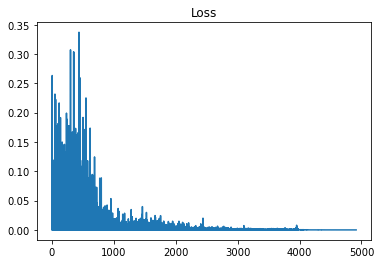

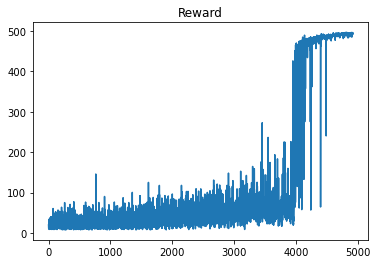

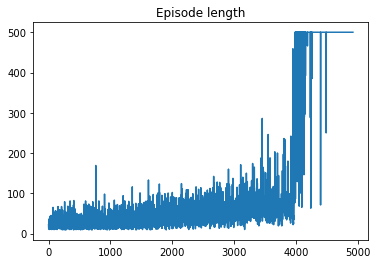

In [52]:
# -|theta| - |x|/10
plot_progress()

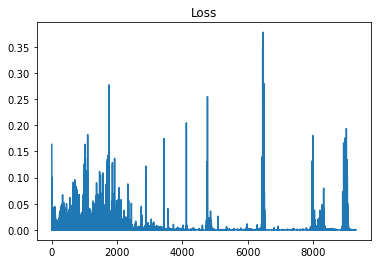

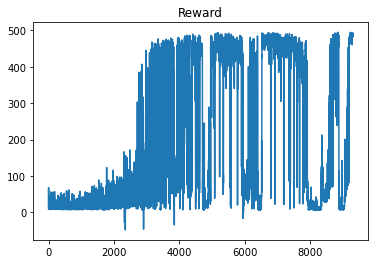

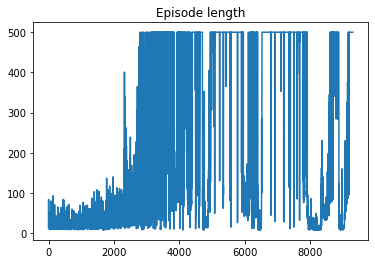

In [22]:
# -|theta| - |x|
plot_progress()

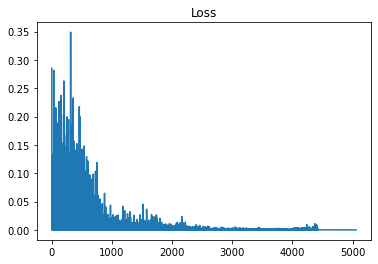

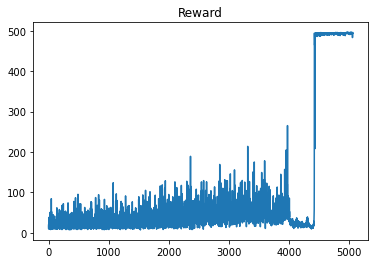

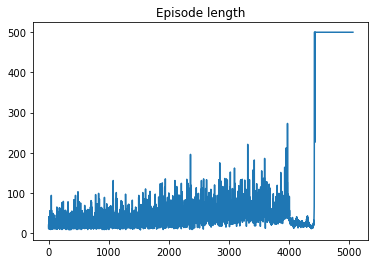

In [34]:
# -|theta|
plot_progress()

In [35]:
def show_performance(agent):
    env = gym.make('CartPole-v1')
    for i in tqdm(range(1)):
        obs, done, rew = env.reset(), False, 0
        while (done != True) :
            A =  agent.get_action(obs, env.action_space.n, epsilon = 0)
            obs, reward, done, info = env.step(A.item())
            rew += reward
            sleep(0.01)
            env.render()  
        print("episode : {}, reward : {}".format(i,rew)) 

In [55]:
show_performance(agent_theta)

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.20s/it]

episode : 0, reward : 500.0


In [53]:
show_performance(agent_both_v2)

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.29s/it]

episode : 0, reward : 500.0


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.25s/it]

episode : 0, reward : 500.0
